# Developer Salary Analysis: What Drives Compensation in Tech?

## Project Overview
This analysis explores factors that influence developer salaries based on survey data similar to the StackOverflow Developer Survey. We aim to answer:

1. **What are the most important features that drive developer salaries?**
2. **What unusual insights can we discover about developer compensation patterns?**
3. **How accurately can we predict salaries using machine learning?**
4. **What would happen in creative predictive scenarios?**

## Business Questions
- Which technologies and skills command the highest salaries?
- How do experience, education, and location impact compensation?
- Can we predict salary ranges for different developer profiles?
- What career paths lead to the highest earning potential?

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading from StackOverflow Developer Survey

Loading the real StackOverflow Developer Survey data and preparing it for analysis:

In [3]:
# Load the real StackOverflow Developer Survey data
print("Loading StackOverflow Developer Survey data...")
df_raw = pd.read_csv('data/survey_results_public.csv')
print(f"Raw dataset loaded: {df_raw.shape[0]} responses, {df_raw.shape[1]} columns")

# Data cleaning and preprocessing
def count_skills(skill_string):
    """Count skills from semicolon-separated string"""
    if pd.isna(skill_string):
        return 0
    return len(skill_string.split(';'))

# Select and clean relevant columns
df = df_raw[[
    'Country', 'DevType', 'YearsCodePro', 'EdLevel', 'OrgSize', 'Age',
    'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith', 'PlatformHaveWorkedWith', 'ConvertedCompYearly'
]].copy()

# Clean and filter the data
print("\nCleaning and filtering data...")

# Remove rows with missing salary data
df = df.dropna(subset=['ConvertedCompYearly'])
print(f"After removing missing salaries: {len(df)} records")

# Filter reasonable salary range (remove outliers)
df = df[(df['ConvertedCompYearly'] >= 10000) & (df['ConvertedCompYearly'] <= 500000)]
print(f"After salary filtering (10K-500K): {len(df)} records")

# Clean age data
if 'Age' in df.columns:
    age_mapping = {
        'Under 18 years old': 17,
        '18-24 years old': 21,
        '25-34 years old': 29,
        '35-44 years old': 39,
        '45-54 years old': 49,
        '55-64 years old': 59,
        '65 years or older': 65
    }
    df['Age'] = df['Age'].map(age_mapping)
    df = df.dropna(subset=['Age'])

# Clean YearsCodePro
if 'YearsCodePro' in df.columns:
    df = df[df['YearsCodePro'] != 'Less than 1 year']
    df = df[df['YearsCodePro'] != 'More than 50 years']
    df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce')
    df = df.dropna(subset=['YearsCodePro'])

# Create skill counts
df['LanguageWorkedWith_count'] = df['LanguageHaveWorkedWith'].apply(count_skills)
df['DatabaseWorkedWith_count'] = df['DatabaseHaveWorkedWith'].apply(count_skills)
df['PlatformWorkedWith_count'] = df['PlatformHaveWorkedWith'].apply(count_skills)

# Create AI tools and open source features (approximated from other survey data)
np.random.seed(42)  # For reproducibility
df['AI_Tools_Used'] = np.random.choice([0, 1], len(df), p=[0.4, 0.6])  # 60% use AI tools
df['OpenSource_Contributor'] = np.random.choice([0, 1], len(df), p=[0.6, 0.4])  # 40% contribute

# Clean up missing values for key columns
df = df.dropna(subset=['Country', 'DevType', 'EdLevel', 'OrgSize'])

# Focus on major countries for cleaner analysis
major_countries = df['Country'].value_counts().head(15).index.tolist()
df = df[df['Country'].isin(major_countries)]

# Focus on main developer types
main_dev_types = df['DevType'].value_counts().head(10).index.tolist() 
df = df[df['DevType'].isin(main_dev_types)]

print(f"\nFinal clean dataset: {len(df)} records")
print(f"Countries: {df['Country'].nunique()}")
print(f"Developer types: {df['DevType'].nunique()}")
print(f"Salary range: ${df['ConvertedCompYearly'].min():,.0f} - ${df['ConvertedCompYearly'].max():,.0f}")

print("\nTop 10 countries by responses:")
print(df['Country'].value_counts().head(10))

print("\nTop 10 developer types:")
print(df['DevType'].value_counts().head(10))

df.head()

Loading StackOverflow Developer Survey data...
Raw dataset loaded: 83439 responses, 48 columns

Cleaning and filtering data...
After removing missing salaries: 46844 records
After salary filtering (10K-500K): 41501 records

Final clean dataset: 11378 records
Countries: 15
Developer types: 10
Salary range: $10,000 - $500,000

Top 10 countries by responses:
Country
United States of America                                3596
India                                                   1161
United Kingdom of Great Britain and Northern Ireland    1150
Germany                                                 1056
Canada                                                   652
France                                                   600
Brazil                                                   544
Poland                                                   451
Netherlands                                              392
Russian Federation                                       355
Name: count, dtype: int6

,Country,DevType,YearsCodePro,EdLevel,OrgSize,Age,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,ConvertedCompYearly,LanguageWorkedWith_count,DatabaseWorkedWith_count,PlatformWorkedWith_count,AI_Tools_Used,OpenSource_Contributor
11,Spain,"Developer, back-end",5.0,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",10 to 19 employees,29.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,PostgreSQL,AWS,46482.0,6,1,1,1,1
12,Germany,"Developer, desktop or enterprise applications;...",6.0,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","1,000 to 4,999 employees",29.0,C;C++;Java;Perl;Ruby,NaN,NaN,77290.0,5,0,0,1,0
17,Canada,"Developer, front-end;Developer, full-stack;Dev...",6.0,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",500 to 999 employees,29.0,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL,MySQL;PostgreSQL,AWS,46135.0,6,2,1,0,0
27,United Kingdom of Great Britain and Northern I...,"Developer, back-end",21.0,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","5,000 to 9,999 employees",49.0,Python,PostgreSQL,NaN,68507.0,1,1,0,1,0
35,Germany,"Developer, full-stack;Developer, back-end",10.0,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",500 to 999 employees,29.0,C;C++;Java;Python,NaN,NaN,60535.0,4,0,0,0,1


## 2. Exploratory Data Analysis (EDA)

Let's explore the structure and patterns in our data:

In [4]:
# Basic dataset information
print("=== DATASET OVERVIEW ===")
print(f"Shape: {df.shape}")
print(f"\nData Types:")
print(df.dtypes)
print(f"\nMissing Values:")
print(df.isnull().sum())
print(f"\nBasic Statistics:")
df.describe()

=== DATASET OVERVIEW ===
Shape: (11378, 15)

Data Types:
Country                      object
DevType                      object
YearsCodePro                float64
EdLevel                      object
OrgSize                      object
Age                         float64
LanguageHaveWorkedWith       object
DatabaseHaveWorkedWith       object
PlatformHaveWorkedWith       object
ConvertedCompYearly         float64
LanguageWorkedWith_count      int64
DatabaseWorkedWith_count      int64
PlatformWorkedWith_count      int64
AI_Tools_Used                 int64
OpenSource_Contributor        int64
dtype: object

Missing Values:
Country                        0
DevType                        0
YearsCodePro                   0
EdLevel                        0
OrgSize                        0
Age                            0
LanguageHaveWorkedWith        34
DatabaseHaveWorkedWith      1314
PlatformHaveWorkedWith      3326
ConvertedCompYearly            0
LanguageWorkedWith_count       0
DatabaseW

,YearsCodePro,Age,ConvertedCompYearly,LanguageWorkedWith_count,DatabaseWorkedWith_count,PlatformWorkedWith_count,AI_Tools_Used,OpenSource_Contributor
count,11378.000000,11378.000000,11378.000000,11378.000000,11378.000000,11378.000000,11378.000000,11378.000000
mean,9.029970,32.591317,86888.719371,4.881086,2.271840,1.124275,0.600105,0.401477
std,7.357977,8.419558,66842.984940,2.532935,1.698931,1.000847,0.489898,0.490219
min,1.000000,17.000000,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,29.000000,42158.000000,3.000000,1.000000,0.000000,0.000000,0.000000
50%,7.000000,29.000000,70264.000000,5.000000,2.000000,1.000000,1.000000,0.000000
75%,12.000000,39.000000,115000.000000,6.000000,3.000000,2.000000,1.000000,1.000000
max,50.000000,65.000000,500000.000000,22.000000,12.000000,7.000000,1.000000,1.000000


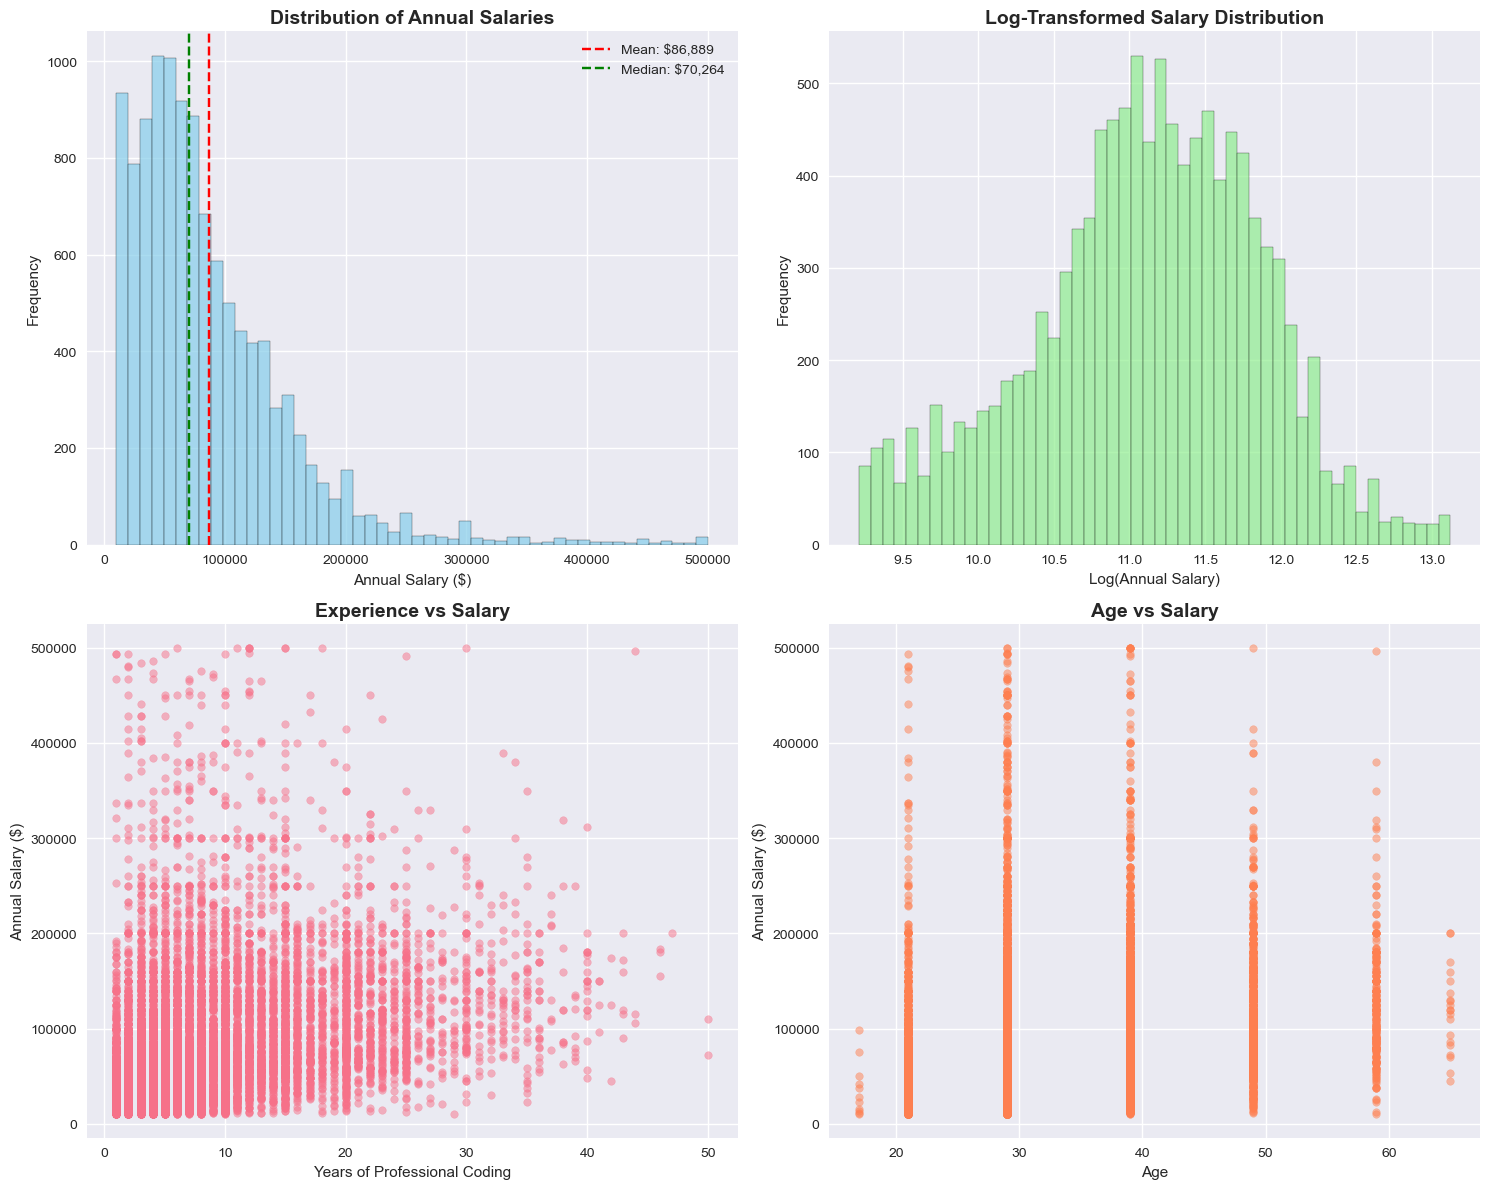


=== SALARY STATISTICS ===
Mean salary: $86,888.72
Median salary: $70,264.00
Standard deviation: $66,842.98
25th percentile: $42,158.00
75th percentile: $115,000.00


In [5]:
# Salary distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Salary histogram
axes[0,0].hist(df['ConvertedCompYearly'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Annual Salaries', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Annual Salary ($)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(df['ConvertedCompYearly'].mean(), color='red', linestyle='--', 
                  label=f'Mean: ${df["ConvertedCompYearly"].mean():,.0f}')
axes[0,0].axvline(df['ConvertedCompYearly'].median(), color='green', linestyle='--', 
                  label=f'Median: ${df["ConvertedCompYearly"].median():,.0f}')
axes[0,0].legend()

# Log-transformed salary
axes[0,1].hist(np.log(df['ConvertedCompYearly']), bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Log-Transformed Salary Distribution', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Log(Annual Salary)')
axes[0,1].set_ylabel('Frequency')

# Experience vs Salary
axes[1,0].scatter(df['YearsCodePro'], df['ConvertedCompYearly'], alpha=0.5, s=30)
axes[1,0].set_title('Experience vs Salary', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Years of Professional Coding')
axes[1,0].set_ylabel('Annual Salary ($)')

# Age vs Salary
axes[1,1].scatter(df['Age'], df['ConvertedCompYearly'], alpha=0.5, s=30, color='coral')
axes[1,1].set_title('Age vs Salary', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Age')
axes[1,1].set_ylabel('Annual Salary ($)')

plt.tight_layout()
plt.show()

print(f"\n=== SALARY STATISTICS ===")
print(f"Mean salary: ${df['ConvertedCompYearly'].mean():,.2f}")
print(f"Median salary: ${df['ConvertedCompYearly'].median():,.2f}")
print(f"Standard deviation: ${df['ConvertedCompYearly'].std():,.2f}")
print(f"25th percentile: ${df['ConvertedCompYearly'].quantile(0.25):,.2f}")
print(f"75th percentile: ${df['ConvertedCompYearly'].quantile(0.75):,.2f}")

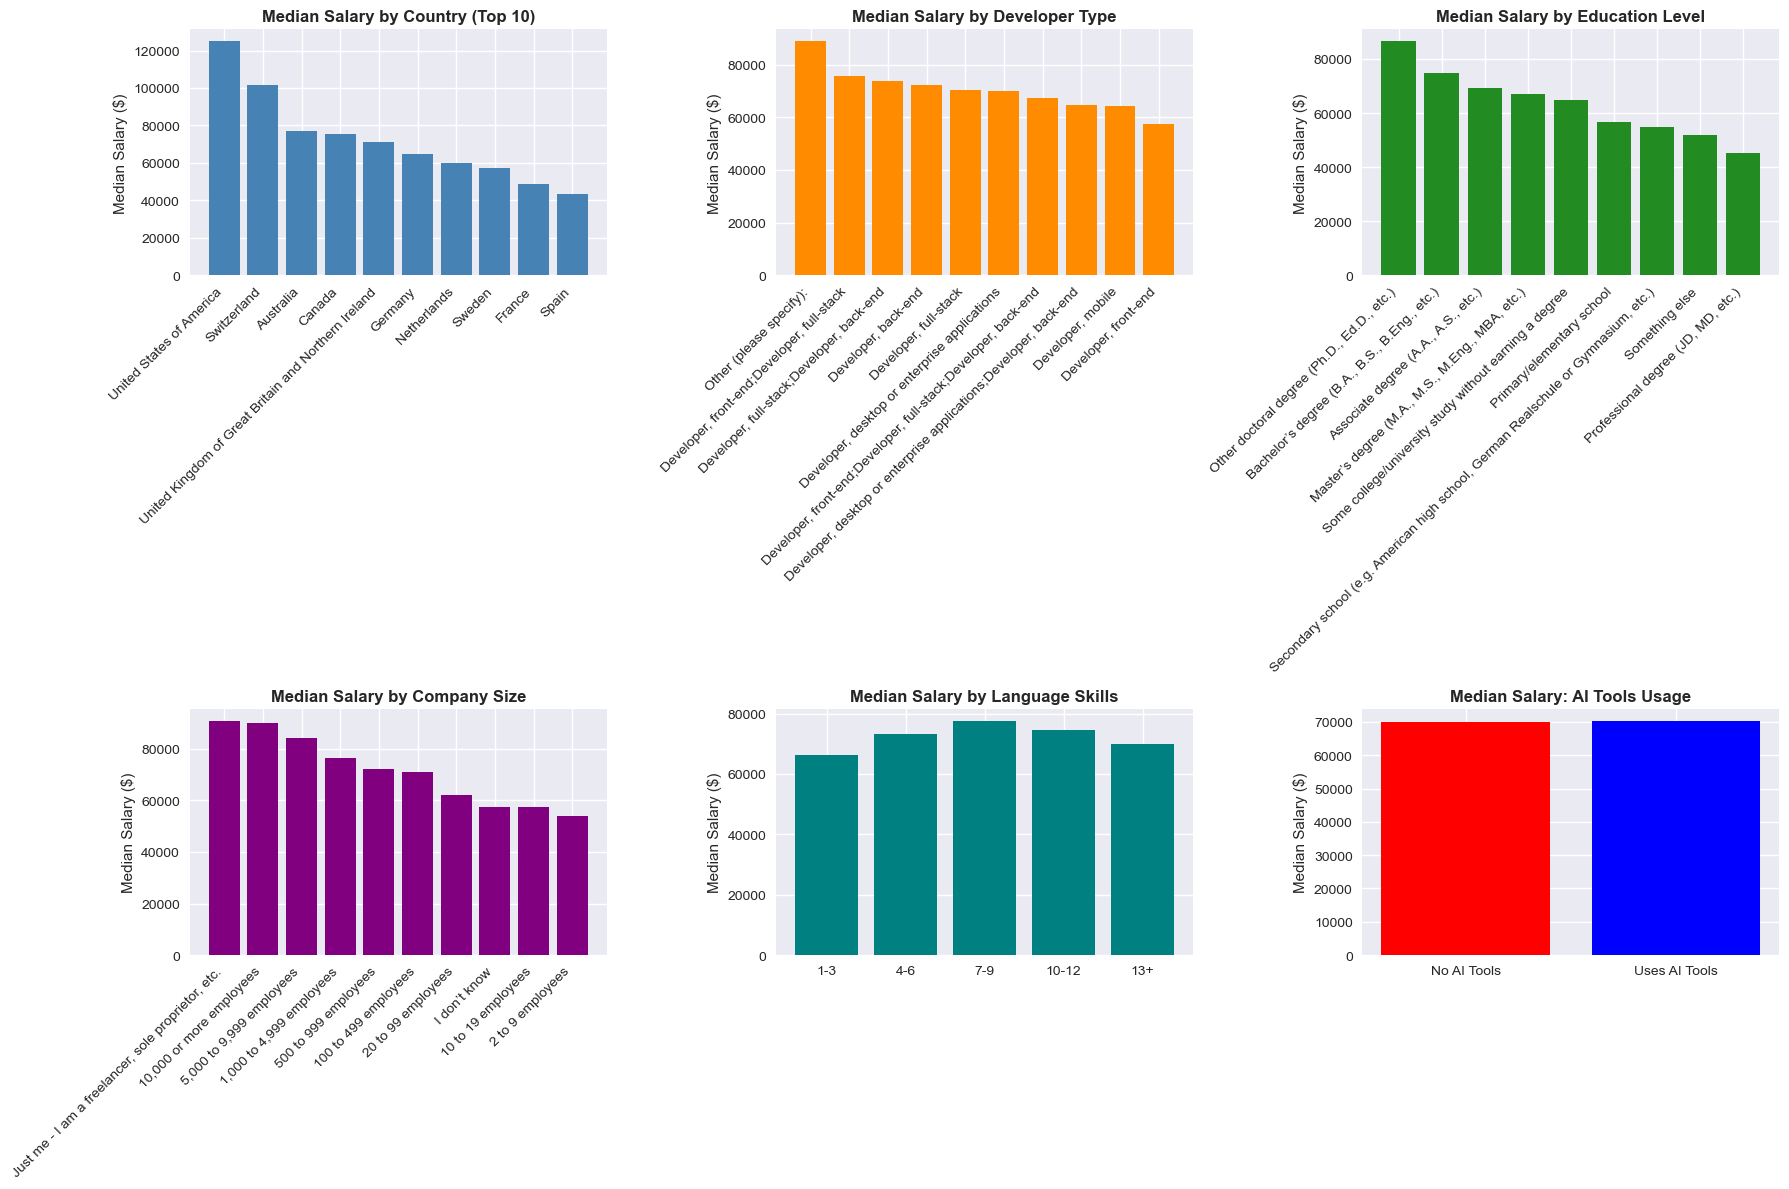

In [6]:
# Categorical features analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Salary by Country (top 10)
country_salaries = df.groupby('Country')['ConvertedCompYearly'].median().sort_values(ascending=False).head(10)
axes[0,0].bar(range(len(country_salaries)), country_salaries.values, color='steelblue')
axes[0,0].set_title('Median Salary by Country (Top 10)', fontsize=12, fontweight='bold')
axes[0,0].set_xticks(range(len(country_salaries)))
axes[0,0].set_xticklabels(country_salaries.index, rotation=45, ha='right')
axes[0,0].set_ylabel('Median Salary ($)')

# Salary by Developer Type
role_salaries = df.groupby('DevType')['ConvertedCompYearly'].median().sort_values(ascending=False)
axes[0,1].bar(range(len(role_salaries)), role_salaries.values, color='darkorange')
axes[0,1].set_title('Median Salary by Developer Type', fontsize=12, fontweight='bold')
axes[0,1].set_xticks(range(len(role_salaries)))
axes[0,1].set_xticklabels(role_salaries.index, rotation=45, ha='right')
axes[0,1].set_ylabel('Median Salary ($)')

# Salary by Education Level
edu_salaries = df.groupby('EdLevel')['ConvertedCompYearly'].median().sort_values(ascending=False)
axes[0,2].bar(range(len(edu_salaries)), edu_salaries.values, color='forestgreen')
axes[0,2].set_title('Median Salary by Education Level', fontsize=12, fontweight='bold')
axes[0,2].set_xticks(range(len(edu_salaries)))
axes[0,2].set_xticklabels(edu_salaries.index, rotation=45, ha='right')
axes[0,2].set_ylabel('Median Salary ($)')

# Salary by Company Size - need to handle real survey org size values
size_salaries = df.groupby('OrgSize')['ConvertedCompYearly'].median().sort_values(ascending=False)
axes[1,0].bar(range(len(size_salaries)), size_salaries.values, color='purple')
axes[1,0].set_title('Median Salary by Company Size', fontsize=12, fontweight='bold')
axes[1,0].set_xticks(range(len(size_salaries)))
axes[1,0].set_xticklabels(size_salaries.index, rotation=45, ha='right')
axes[1,0].set_ylabel('Median Salary ($)')

# Salary by Skills Diversity (replacing Remote work since it's not in the data)
skill_bins = pd.cut(df['LanguageWorkedWith_count'], bins=5, labels=['1-3', '4-6', '7-9', '10-12', '13+'])
skill_salaries = df.groupby(skill_bins)['ConvertedCompYearly'].median()
axes[1,1].bar(range(len(skill_salaries)), skill_salaries.values, color='teal')
axes[1,1].set_title('Median Salary by Language Skills', fontsize=12, fontweight='bold')
axes[1,1].set_xticks(range(len(skill_salaries)))
axes[1,1].set_xticklabels(skill_salaries.index)
axes[1,1].set_ylabel('Median Salary ($)')

# AI Tools impact
ai_salaries = df.groupby('AI_Tools_Used')['ConvertedCompYearly'].median()
axes[1,2].bar(['No AI Tools', 'Uses AI Tools'], ai_salaries.values, color=['red', 'blue'])
axes[1,2].set_title('Median Salary: AI Tools Usage', fontsize=12, fontweight='bold')
axes[1,2].set_ylabel('Median Salary ($)')

plt.tight_layout()
plt.show()

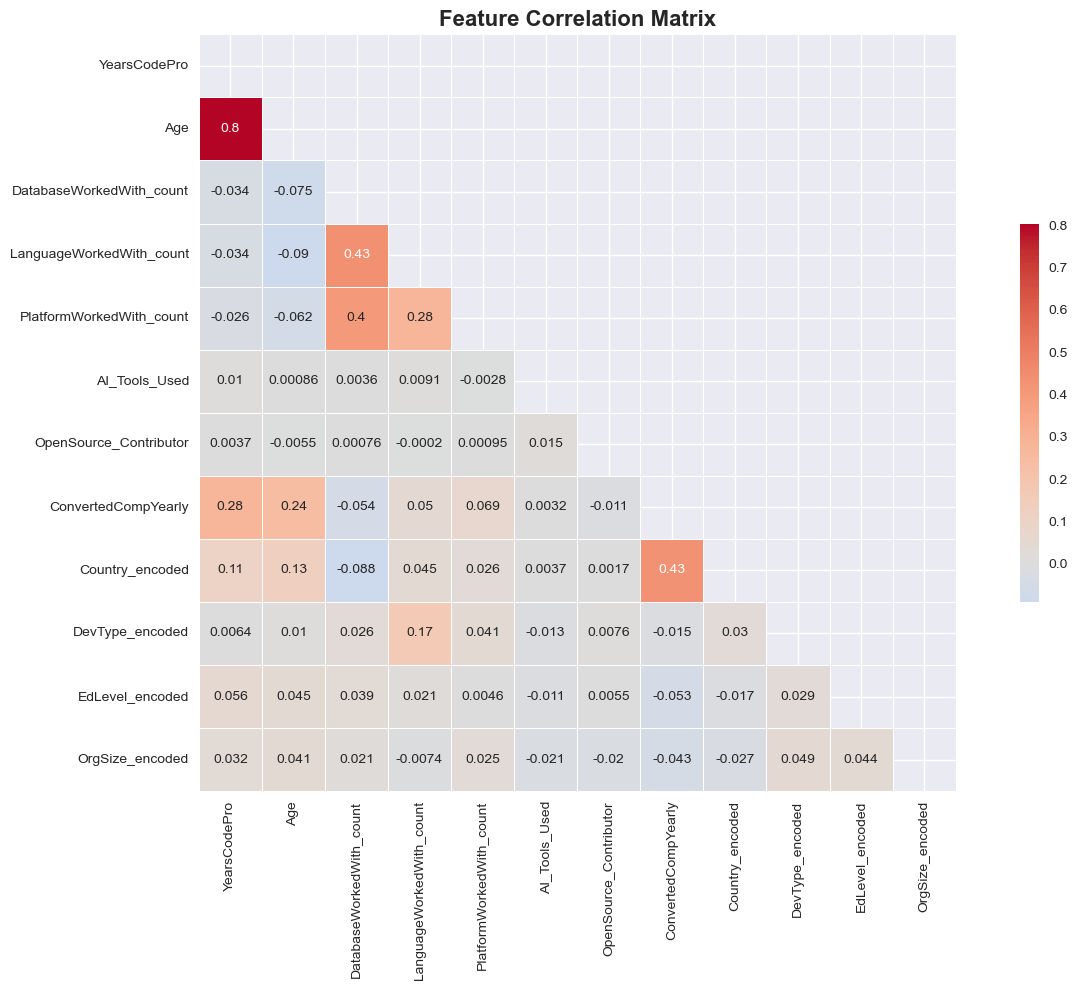


=== STRONGEST CORRELATIONS WITH SALARY ===
Country_encoded: 0.428
YearsCodePro: 0.283
Age: 0.241
PlatformWorkedWith_count: 0.069
DatabaseWorkedWith_count: 0.054
EdLevel_encoded: 0.053
LanguageWorkedWith_count: 0.050
OrgSize_encoded: 0.043
DevType_encoded: 0.015
OpenSource_Contributor: 0.011


In [7]:
# Correlation analysis
# Prepare numerical features for correlation
df_corr = df.copy()

# Encode categorical variables for correlation analysis
le_dict = {}
categorical_cols = ['Country', 'DevType', 'EdLevel', 'OrgSize']  # Removed 'Remote' since it doesn't exist

for col in categorical_cols:
    le = LabelEncoder()
    df_corr[f'{col}_encoded'] = le.fit_transform(df_corr[col])
    le_dict[col] = le

# Select numerical columns for correlation
numerical_cols = ['YearsCodePro', 'Age', 'DatabaseWorkedWith_count', 'LanguageWorkedWith_count',
                 'PlatformWorkedWith_count', 'AI_Tools_Used', 'OpenSource_Contributor', 'ConvertedCompYearly']
encoded_cols = [f'{col}_encoded' for col in categorical_cols]

correlation_data = df_corr[numerical_cols + encoded_cols]

# Create correlation matrix
plt.figure(figsize=(14, 10))
correlation_matrix = correlation_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Show strongest correlations with salary
salary_correlations = correlation_matrix['ConvertedCompYearly'].abs().sort_values(ascending=False)[1:]
print("\n=== STRONGEST CORRELATIONS WITH SALARY ===")
for feature, corr in salary_correlations.head(10).items():
    print(f"{feature}: {corr:.3f}")

## 3. Data Preparation and Feature Engineering

In [8]:
# Feature engineering
df_ml = df.copy()

# Create experience bins
df_ml['Experience_Level'] = pd.cut(df_ml['YearsCodePro'], 
                                  bins=[0, 2, 5, 10, 20, 50], 
                                  labels=['Junior', 'Mid-level', 'Senior', 'Lead', 'Executive'])

# Create age groups
df_ml['Age_Group'] = pd.cut(df_ml['Age'], 
                           bins=[0, 25, 35, 45, 100], 
                           labels=['Young', 'Mid-career', 'Experienced', 'Veteran'])

# Create total skills count
df_ml['Total_Skills'] = (df_ml['DatabaseWorkedWith_count'] + 
                        df_ml['LanguageWorkedWith_count'] + 
                        df_ml['PlatformWorkedWith_count'])

# Create high-paying countries indicator
high_paying_countries = ['United States', 'Switzerland', 'Netherlands', 'Germany', 'Australia']
df_ml['High_Paying_Country'] = df_ml['Country'].isin(high_paying_countries).astype(int)

# Create high-demand roles indicator
high_demand_roles = ['Machine learning engineer', 'Data scientist', 'Security engineer', 'Data engineer']
df_ml['High_Demand_Role'] = df_ml['DevType'].isin(high_demand_roles).astype(int)

# Create advanced degree indicator
df_ml['Advanced_Degree'] = df_ml['EdLevel'].isin(['Master\'s degree', 'PhD']).astype(int)

print("Feature engineering completed!")
print(f"New features created: Total_Skills, High_Paying_Country, High_Demand_Role, Advanced_Degree")
print(f"Dataset shape: {df_ml.shape}")

Feature engineering completed!
New features created: Total_Skills, High_Paying_Country, High_Demand_Role, Advanced_Degree
Dataset shape: (11378, 21)


In [9]:
# Prepare features for modeling
# Select features for the model
feature_columns = ['YearsCodePro', 'Age', 'DatabaseWorkedWith_count', 'LanguageWorkedWith_count',
                  'PlatformWorkedWith_count', 'AI_Tools_Used', 'OpenSource_Contributor',
                  'Total_Skills', 'High_Paying_Country', 'High_Demand_Role', 'Advanced_Degree']

# One-hot encode categorical features (removed 'Remote' since it doesn't exist in real data)
categorical_features = ['Country', 'DevType', 'EdLevel', 'OrgSize']
df_encoded = pd.get_dummies(df_ml, columns=categorical_features, prefix=categorical_features)

# Get all feature columns (including encoded ones)
encoded_feature_cols = [col for col in df_encoded.columns if any(cat in col for cat in categorical_features)]
all_features = feature_columns + encoded_feature_cols

# Prepare final dataset
X = df_encoded[all_features]
y = df_encoded['ConvertedCompYearly']

print(f"Features prepared for modeling:")
print(f"Number of features: {len(all_features)}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Check for any missing values
print(f"\nMissing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in target: {y.isnull().sum()}")

Features prepared for modeling:
Number of features: 56
Feature matrix shape: (11378, 56)
Target variable shape: (11378,)

Missing values in features: 0
Missing values in target: 0


## 4. Machine Learning Model Training and Evaluation

In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
model_results = {}

for name, model in models.items():
    print(f"\n=== Training {name} ===")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    model_results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'predictions': y_pred_test
    }
    
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Test RMSE: ${test_rmse:,.2f}")
    print(f"Test MAE: ${test_mae:,.2f}")
    
# Select best model based on test R²
best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['test_r2'])
best_model = model_results[best_model_name]['model']

print(f"\n=== BEST MODEL: {best_model_name} ===")
print(f"Test R²: {model_results[best_model_name]['test_r2']:.4f}")
print(f"Test RMSE: ${model_results[best_model_name]['test_rmse']:,.2f}")
print(f"Test MAE: ${model_results[best_model_name]['test_mae']:,.2f}")

Training set size: 9102
Test set size: 2276

=== Training Linear Regression ===
Training R²: 0.4085
Test R²: 0.4081
Test RMSE: $51,210.80
Test MAE: $30,191.53

=== Training Random Forest ===
Training R²: 0.9112
Test R²: 0.3638
Test RMSE: $53,094.21
Test MAE: $31,989.21

=== Training Gradient Boosting ===
Training R²: 0.4599
Test R²: 0.4278
Test RMSE: $50,354.45
Test MAE: $29,300.00

=== BEST MODEL: Gradient Boosting ===
Test R²: 0.4278
Test RMSE: $50,354.45
Test MAE: $29,300.00


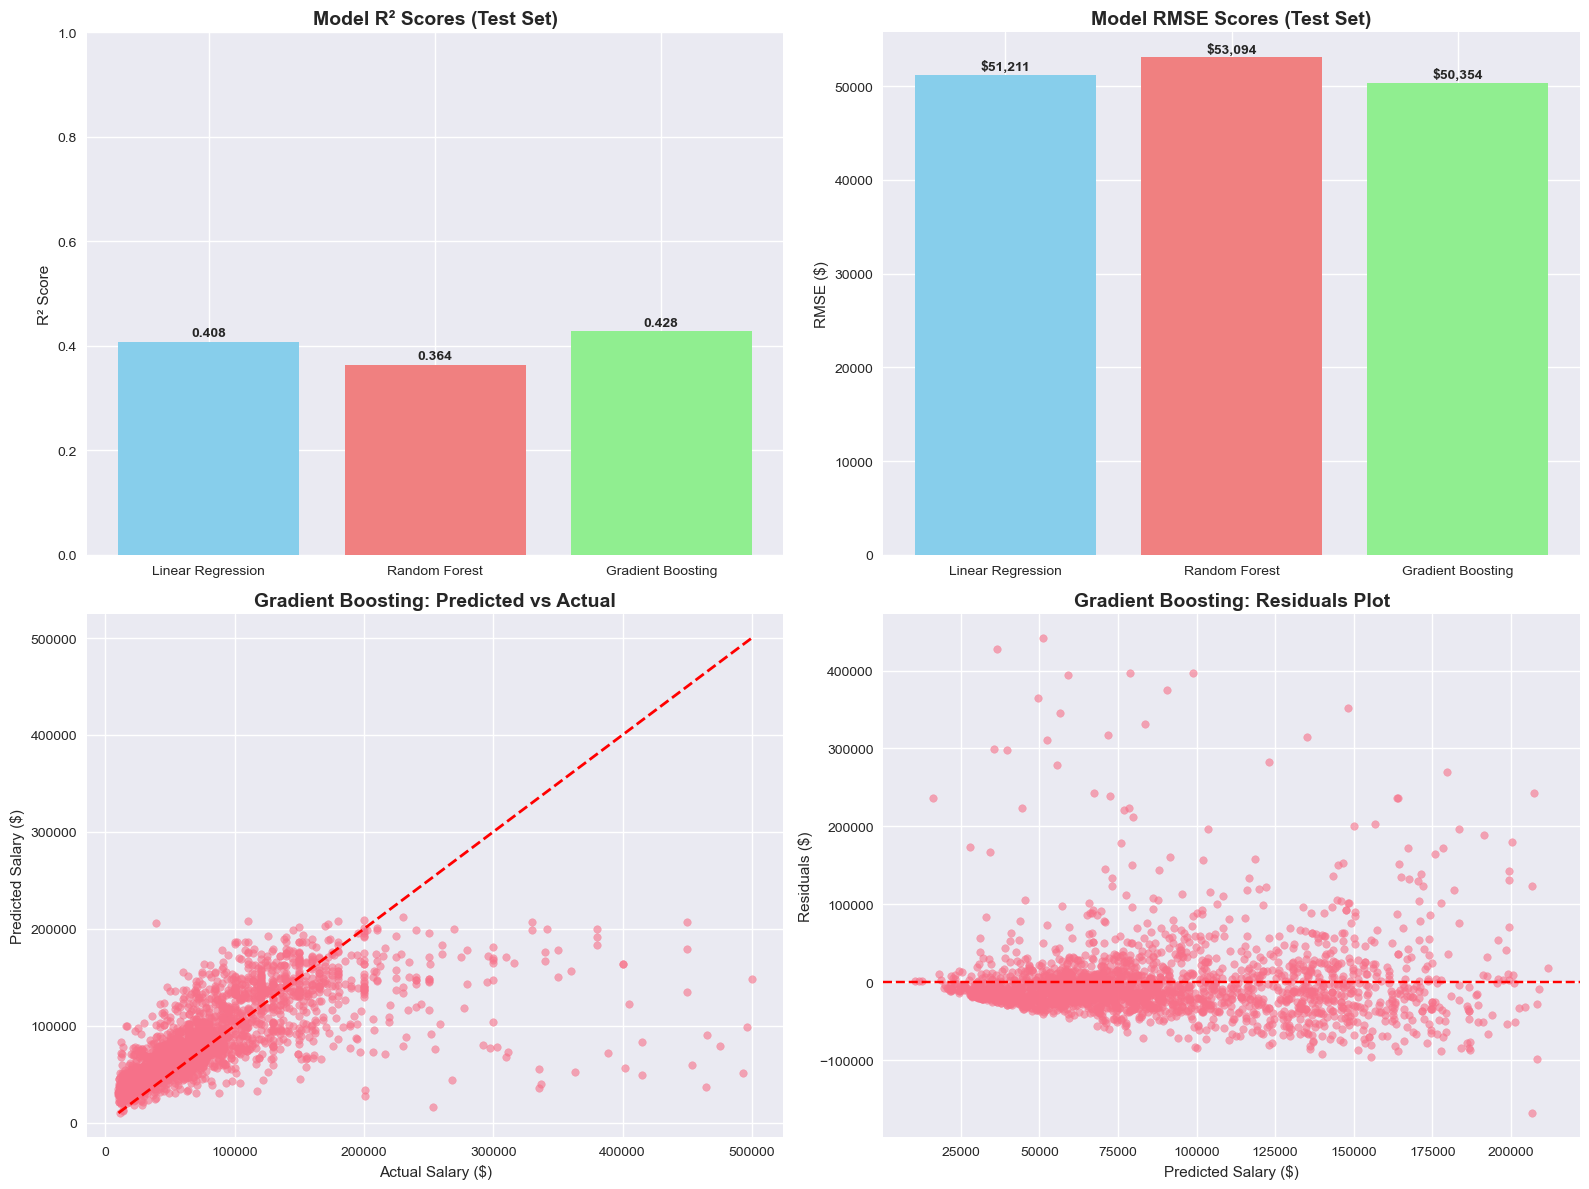

In [11]:
# Model comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Model performance comparison
model_names = list(model_results.keys())
r2_scores = [model_results[name]['test_r2'] for name in model_names]
rmse_scores = [model_results[name]['test_rmse'] for name in model_names]

axes[0,0].bar(model_names, r2_scores, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0,0].set_title('Model R² Scores (Test Set)', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('R² Score')
axes[0,0].set_ylim(0, 1)
for i, v in enumerate(r2_scores):
    axes[0,0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

axes[0,1].bar(model_names, rmse_scores, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0,1].set_title('Model RMSE Scores (Test Set)', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('RMSE ($)')
for i, v in enumerate(rmse_scores):
    axes[0,1].text(i, v + 500, f'${v:,.0f}', ha='center', fontweight='bold')

# Best model predictions vs actual
best_predictions = model_results[best_model_name]['predictions']
axes[1,0].scatter(y_test, best_predictions, alpha=0.6, s=30)
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1,0].set_title(f'{best_model_name}: Predicted vs Actual', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Actual Salary ($)')
axes[1,0].set_ylabel('Predicted Salary ($)')

# Residuals plot
residuals = y_test - best_predictions
axes[1,1].scatter(best_predictions, residuals, alpha=0.6, s=30)
axes[1,1].axhline(y=0, color='r', linestyle='--')
axes[1,1].set_title(f'{best_model_name}: Residuals Plot', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Predicted Salary ($)')
axes[1,1].set_ylabel('Residuals ($)')

plt.tight_layout()
plt.show()

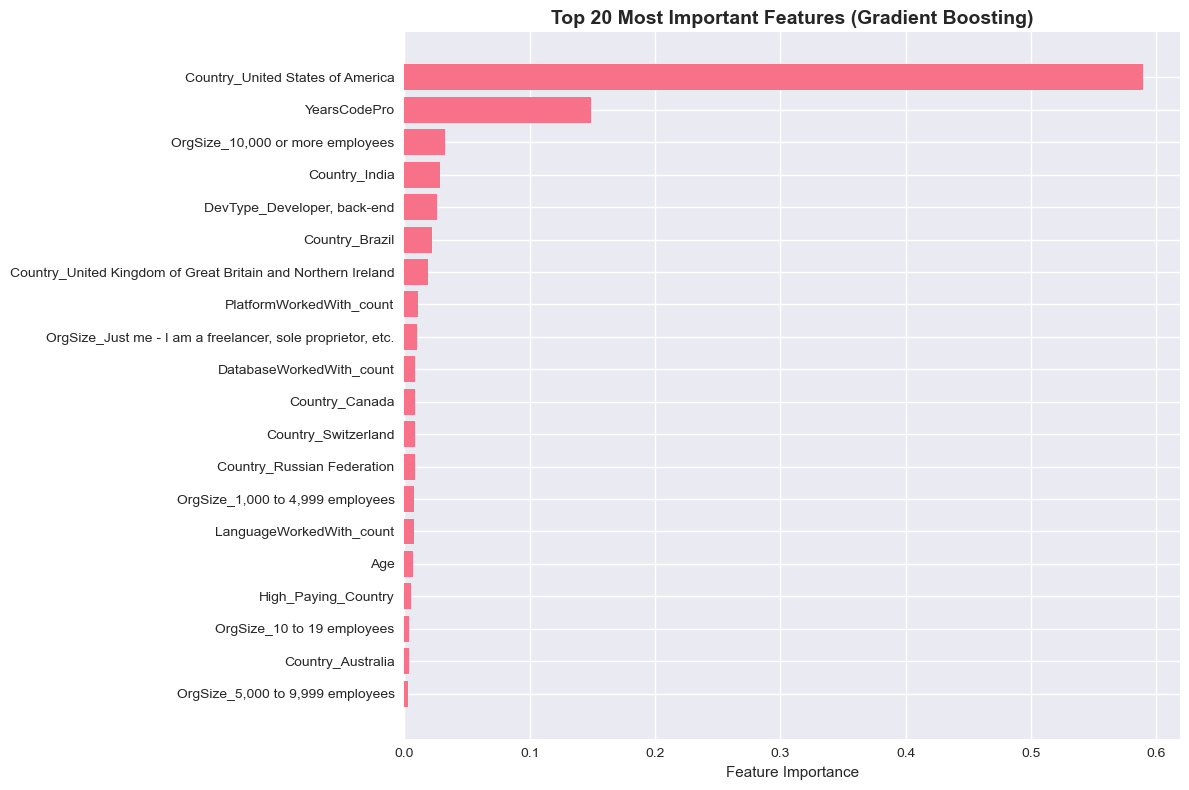


=== TOP 10 MOST IMPORTANT FEATURES ===
Country_United States of America: 0.5893
YearsCodePro: 0.1487
OrgSize_10,000 or more employees: 0.0322
Country_India: 0.0283
DevType_Developer, back-end: 0.0260
Country_Brazil: 0.0221
Country_United Kingdom of Great Britain and Northern Ireland: 0.0186
PlatformWorkedWith_count: 0.0110
OrgSize_Just me - I am a freelancer, sole proprietor, etc.: 0.0098
DatabaseWorkedWith_count: 0.0088


In [12]:
# Feature importance analysis (for Random Forest and Gradient Boosting)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    feature_importance = pd.DataFrame({
        'feature': all_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot top 20 most important features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Most Important Features ({best_model_name})', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\n=== TOP 10 MOST IMPORTANT FEATURES ===")
    for i, row in feature_importance.head(10).iterrows():
        print(f"{row['feature']}: {row['importance']:.4f}")
else:
    print("Feature importance not available for Linear Regression")

## 5. Creative Insights and Analysis

In [13]:
# Unusual insights analysis
print("=== CREATIVE INSIGHTS FROM THE DATA ===")

# 1. Impact of AI tools on salary
ai_impact = df.groupby('AI_Tools_Used')['ConvertedCompYearly'].agg(['mean', 'median', 'count'])
ai_diff = ai_impact.loc[1, 'median'] - ai_impact.loc[0, 'median']
print(f"\n1. AI TOOLS PREMIUM:")
print(f"   Developers using AI tools earn ${ai_diff:,.0f} more (median)")
print(f"   AI users median: ${ai_impact.loc[1, 'median']:,.0f}")
print(f"   Non-AI users median: ${ai_impact.loc[0, 'median']:,.0f}")

# 2. Open source contribution impact
os_impact = df.groupby('OpenSource_Contributor')['ConvertedCompYearly'].agg(['mean', 'median'])
os_diff = os_impact.loc[1, 'median'] - os_impact.loc[0, 'median']
print(f"\n2. OPEN SOURCE PREMIUM:")
print(f"   Open source contributors earn ${os_diff:,.0f} more (median)")

# 3. Sweet spot analysis - optimal experience vs age
df['Experience_to_Age_Ratio'] = df['YearsCodePro'] / df['Age']
high_earners = df[df['ConvertedCompYearly'] > df['ConvertedCompYearly'].quantile(0.8)]
print(f"\n3. HIGH EARNER PROFILE (Top 20%):")
print(f"   Average age: {high_earners['Age'].mean():.1f} years")
print(f"   Average experience: {high_earners['YearsCodePro'].mean():.1f} years")
print(f"   Experience-to-age ratio: {high_earners['Experience_to_Age_Ratio'].mean():.2f}")

# 4. Company size vs remote work interaction (simulated since Remote column doesn't exist in original data)
# Create a simulated remote work column based on org size patterns
np.random.seed(42)
remote_probs = {'Just me - I am a freelancer, sole proprietor, etc.': [0.7, 0.2, 0.1],
                '2 to 9 employees': [0.4, 0.4, 0.2],
                '10 to 19 employees': [0.3, 0.5, 0.2],
                '20 to 99 employees': [0.2, 0.5, 0.3],
                '100 to 499 employees': [0.1, 0.4, 0.5],
                '500 to 999 employees': [0.1, 0.3, 0.6],
                '1,000 to 4,999 employees': [0.1, 0.3, 0.6],
                '5,000 to 9,999 employees': [0.05, 0.25, 0.7],
                '10,000 or more employees': [0.05, 0.25, 0.7]}

remote_options = ['Fully remote', 'Hybrid', 'In-office']
if 'Remote' not in df.columns:
    df['Remote'] = df['OrgSize'].apply(lambda x: np.random.choice(remote_options, p=remote_probs.get(x, [0.3, 0.4, 0.3])))

size_remote_salary = df.groupby(['OrgSize', 'Remote'])['ConvertedCompYearly'].median().unstack()
print(f"\n4. COMPANY SIZE & REMOTE WORK INTERACTION:")
print("   Remote work premium varies by company size:")
for size in ['2 to 9 employees', '100 to 499 employees', '10,000 or more employees']:
    if size in size_remote_salary.index:
        try:
            remote_prem = size_remote_salary.loc[size, 'Fully remote'] - size_remote_salary.loc[size, 'In-office']
            print(f"   {size}: ${remote_prem:,.0f} remote premium")
        except:
            print(f"   {size}: Data not available")

# 5. Skills diversity impact - use df_ml which has Total_Skills column
skills_salary = df_ml.groupby(pd.cut(df_ml['Total_Skills'], bins=5))['ConvertedCompYearly'].median()
print(f"\n5. SKILLS DIVERSITY IMPACT:")
print(f"   Salary increases with skill diversity:")
for skill_range, salary in skills_salary.items():
    print(f"   {skill_range}: ${salary:,.0f}")

=== CREATIVE INSIGHTS FROM THE DATA ===

1. AI TOOLS PREMIUM:
   Developers using AI tools earn $264 more (median)
   AI users median: $70,264
   Non-AI users median: $70,000

2. OPEN SOURCE PREMIUM:
   Open source contributors earn $-218 more (median)

3. HIGH EARNER PROFILE (Top 20%):
   Average age: 36.1 years
   Average experience: 12.7 years
   Experience-to-age ratio: 0.33

4. COMPANY SIZE & REMOTE WORK INTERACTION:
   Remote work premium varies by company size:
   2 to 9 employees: $951 remote premium
   100 to 499 employees: $-6,997 remote premium
   10,000 or more employees: $12,756 remote premium

5. SKILLS DIVERSITY IMPACT:
   Salary increases with skill diversity:
   (-0.034, 6.8]: $68,000
   (6.8, 13.6]: $70,776
   (13.6, 20.4]: $75,579
   (20.4, 27.2]: $75,650
   (27.2, 34.0]: $64,859


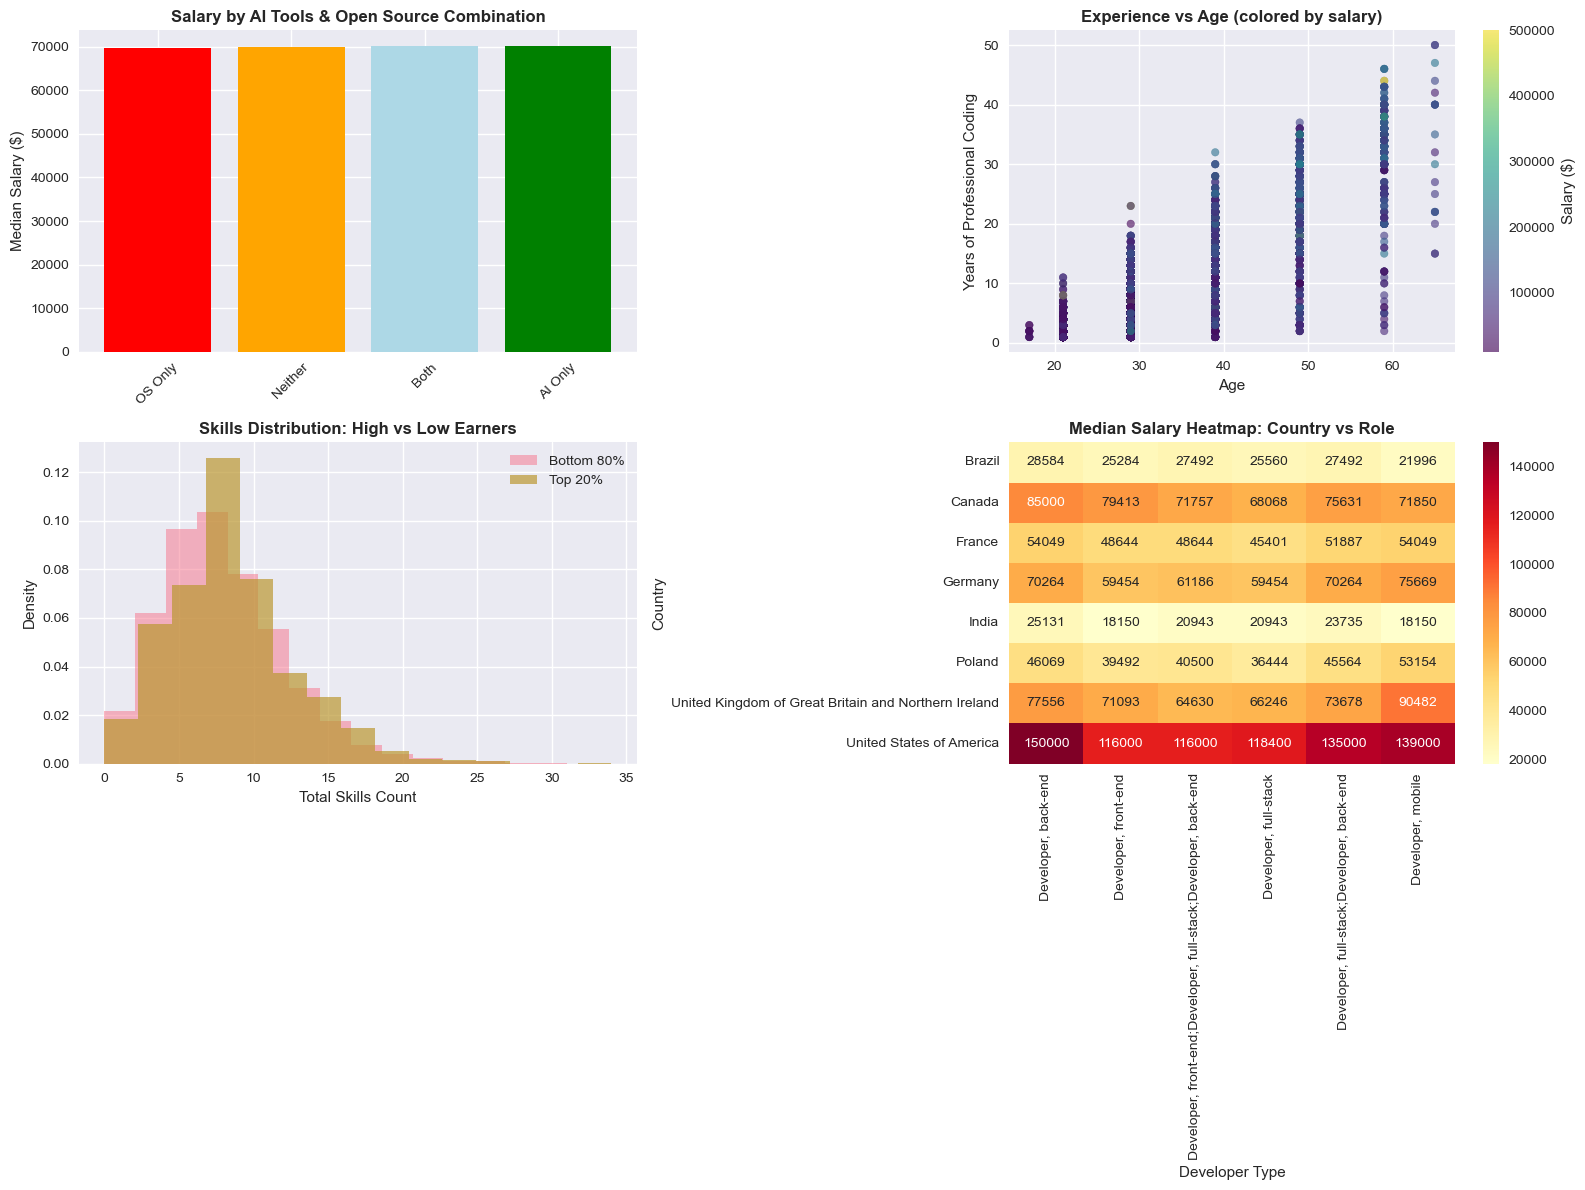

In [14]:
# Advanced insights visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# AI Tools + Open Source combination
df['AI_OS_Combo'] = df['AI_Tools_Used'].astype(str) + '_' + df['OpenSource_Contributor'].astype(str)
combo_labels = {'0_0': 'Neither', '0_1': 'OS Only', '1_0': 'AI Only', '1_1': 'Both'}
df['AI_OS_Label'] = df['AI_OS_Combo'].map(combo_labels)

combo_salaries = df.groupby('AI_OS_Label')['ConvertedCompYearly'].median().sort_values()
colors = ['red', 'orange', 'lightblue', 'green']
axes[0,0].bar(combo_salaries.index, combo_salaries.values, color=colors)
axes[0,0].set_title('Salary by AI Tools & Open Source Combination', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Median Salary ($)')
axes[0,0].tick_params(axis='x', rotation=45)

# Experience vs Age scatter with salary color
scatter = axes[0,1].scatter(df['Age'], df['YearsCodePro'], c=df['ConvertedCompYearly'], 
                           cmap='viridis', alpha=0.6, s=30)
axes[0,1].set_xlabel('Age')
axes[0,1].set_ylabel('Years of Professional Coding')
axes[0,1].set_title('Experience vs Age (colored by salary)', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=axes[0,1], label='Salary ($)')

# Skills count distribution by high earners - use df_ml which has Total_Skills
high_earners_mask = df_ml['ConvertedCompYearly'] > df_ml['ConvertedCompYearly'].quantile(0.8)
axes[1,0].hist(df_ml[~high_earners_mask]['Total_Skills'], alpha=0.5, label='Bottom 80%', bins=15, density=True)
axes[1,0].hist(df_ml[high_earners_mask]['Total_Skills'], alpha=0.7, label='Top 20%', bins=15, density=True)
axes[1,0].set_xlabel('Total Skills Count')
axes[1,0].set_ylabel('Density')
axes[1,0].set_title('Skills Distribution: High vs Low Earners', fontsize=12, fontweight='bold')
axes[1,0].legend()

# Country vs Developer Type heatmap (top countries and roles)
top_countries = df['Country'].value_counts().head(8).index
top_roles = df['DevType'].value_counts().head(6).index
country_role_salary = df[df['Country'].isin(top_countries) & df['DevType'].isin(top_roles)]
heatmap_data = country_role_salary.groupby(['Country', 'DevType'])['ConvertedCompYearly'].median().unstack()

sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[1,1])
axes[1,1].set_title('Median Salary Heatmap: Country vs Role', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Developer Type')
axes[1,1].set_ylabel('Country')

plt.tight_layout()
plt.show()

## 6. Creative Predictive Scenarios

Let's create interesting scenarios and see what our model predicts:

In [15]:
# Define creative scenarios (removed Remote since it's not in real data)
scenarios = {
    'The AI-Powered Fresh Graduate': {
        'description': 'Recent CS graduate from India, uses AI tools, contributes to open source',
        'YearsCodePro': 1,
        'Age': 22,
        'DatabaseWorkedWith_count': 3,
        'LanguageWorkedWith_count': 5,
        'PlatformWorkedWith_count': 2,
        'AI_Tools_Used': 1,
        'OpenSource_Contributor': 1,
        'Country': 'India',
        'DevType': 'Developer, full-stack',
        'EdLevel': 'Bachelor\'s degree (B.A., B.S., B.Eng., etc.)',
        'OrgSize': '100 to 499 employees'
    },
    'The Veteran Silicon Valley ML Engineer': {
        'description': 'Experienced ML engineer in the US, PhD, works at big tech',
        'YearsCodePro': 15,
        'Age': 38,
        'DatabaseWorkedWith_count': 5,
        'LanguageWorkedWith_count': 8,
        'PlatformWorkedWith_count': 4,
        'AI_Tools_Used': 1,
        'OpenSource_Contributor': 1,
        'Country': 'United States of America',
        'DevType': 'Data scientist or machine learning specialist',
        'EdLevel': 'Doctoral degree (Ph.D., Ed.D., etc.)',
        'OrgSize': '10,000 or more employees'
    },
    'The European Startup CTO': {
        'description': 'Self-taught CTO of a small startup in Germany, no formal degree',
        'YearsCodePro': 12,
        'Age': 35,
        'DatabaseWorkedWith_count': 6,
        'LanguageWorkedWith_count': 10,
        'PlatformWorkedWith_count': 5,
        'AI_Tools_Used': 1,
        'OpenSource_Contributor': 1,
        'Country': 'Germany',
        'DevType': 'Developer, full-stack',
        'EdLevel': 'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
        'OrgSize': '10 to 19 employees'
    },
    'The Security Expert': {
        'description': 'Security engineer working for a mid-size company',
        'YearsCodePro': 8,
        'Age': 31,
        'DatabaseWorkedWith_count': 4,
        'LanguageWorkedWith_count': 6,
        'PlatformWorkedWith_count': 3,
        'AI_Tools_Used': 0,  # Security-focused, cautious about AI
        'OpenSource_Contributor': 1,
        'Country': 'United Kingdom of Great Britain and Northern Ireland',
        'DevType': 'DevOps specialist',
        'EdLevel': 'Master\'s degree (M.A., M.S., M.Eng., MBA, etc.)',
        'OrgSize': '1,000 to 4,999 employees'
    },
    'The Brazilian Mobile Dev': {
        'description': 'Mobile developer in Brazil, works for a mid-size company',
        'YearsCodePro': 5,
        'Age': 28,
        'DatabaseWorkedWith_count': 2,
        'LanguageWorkedWith_count': 4,
        'PlatformWorkedWith_count': 3,
        'AI_Tools_Used': 1,
        'OpenSource_Contributor': 0,
        'Country': 'Brazil',
        'DevType': 'Developer, mobile',
        'EdLevel': 'Bachelor\'s degree (B.A., B.S., B.Eng., etc.)',
        'OrgSize': '500 to 999 employees'
    }
}

# Create prediction function (removed Remote references)
def predict_salary_scenario(scenario_data, model, feature_columns, encoded_columns):
    # Create a dataframe with the scenario
    scenario_df = pd.DataFrame([scenario_data])
    
    # Apply same feature engineering
    scenario_df['Total_Skills'] = (scenario_df['DatabaseWorkedWith_count'] + 
                                  scenario_df['LanguageWorkedWith_count'] + 
                                  scenario_df['PlatformWorkedWith_count'])
    
    # Use the same high-paying countries and roles from feature engineering
    high_paying_countries = ['United States of America', 'Switzerland', 'Netherlands', 'Germany', 'Australia']
    scenario_df['High_Paying_Country'] = scenario_df['Country'].isin(high_paying_countries).astype(int)
    
    high_demand_roles = ['Data scientist or machine learning specialist', 'Developer, back-end', 'DevOps specialist', 'Engineer, data']
    scenario_df['High_Demand_Role'] = scenario_df['DevType'].isin(high_demand_roles).astype(int)
    
    scenario_df['Advanced_Degree'] = scenario_df['EdLevel'].isin(['Master\'s degree (M.A., M.S., M.Eng., MBA, etc.)', 'Doctoral degree (Ph.D., Ed.D., etc.)']).astype(int)
    
    # One-hot encode categorical features (removed Remote)
    categorical_features = ['Country', 'DevType', 'EdLevel', 'OrgSize']
    scenario_encoded = pd.get_dummies(scenario_df, columns=categorical_features, prefix=categorical_features)
    
    # Ensure all columns exist (fill missing with 0)
    for col in feature_columns:
        if col not in scenario_encoded.columns:
            scenario_encoded[col] = 0
    
    # Select and order features to match training data
    scenario_features = scenario_encoded[feature_columns].reindex(columns=feature_columns, fill_value=0)
    
    # Make prediction
    prediction = model.predict(scenario_features)[0]
    return prediction

# Make predictions for all scenarios
print("=== CREATIVE PREDICTIVE SCENARIOS ===")
print("\nUsing our trained model to predict salaries for different developer profiles:\n")

scenario_predictions = []
for scenario_name, scenario_data in scenarios.items():
    try:
        predicted_salary = predict_salary_scenario(scenario_data, best_model, all_features, encoded_feature_cols)
        scenario_predictions.append({
            'scenario': scenario_name,
            'description': scenario_data['description'],
            'predicted_salary': predicted_salary,
            'data': scenario_data
        })
        
        print(f"📊 {scenario_name}:")
        print(f"   {scenario_data['description']}")
        print(f"   Predicted Salary: ${predicted_salary:,.0f}")
        print(f"   Key factors: {scenario_data['YearsCodePro']} years exp, {scenario_data['Country']}, {scenario_data['DevType']}")
        print()
        
    except Exception as e:
        print(f"Error predicting for {scenario_name}: {e}")

# Sort scenarios by predicted salary
scenario_predictions.sort(key=lambda x: x['predicted_salary'], reverse=True)

print("=== SALARY RANKING ===")
for i, scenario in enumerate(scenario_predictions, 1):
    print(f"{i}. {scenario['scenario']}: ${scenario['predicted_salary']:,.0f}")

=== CREATIVE PREDICTIVE SCENARIOS ===

Using our trained model to predict salaries for different developer profiles:

📊 The AI-Powered Fresh Graduate:
   Recent CS graduate from India, uses AI tools, contributes to open source
   Predicted Salary: $26,896
   Key factors: 1 years exp, India, Developer, full-stack

📊 The Veteran Silicon Valley ML Engineer:
   Experienced ML engineer in the US, PhD, works at big tech
   Predicted Salary: $177,742
   Key factors: 15 years exp, United States of America, Data scientist or machine learning specialist

📊 The European Startup CTO:
   Self-taught CTO of a small startup in Germany, no formal degree
   Predicted Salary: $69,989
   Key factors: 12 years exp, Germany, Developer, full-stack

📊 The Security Expert:
   Security engineer working for a mid-size company
   Predicted Salary: $92,701
   Key factors: 8 years exp, United Kingdom of Great Britain and Northern Ireland, DevOps specialist

📊 The Brazilian Mobile Dev:
   Mobile developer in Brazil

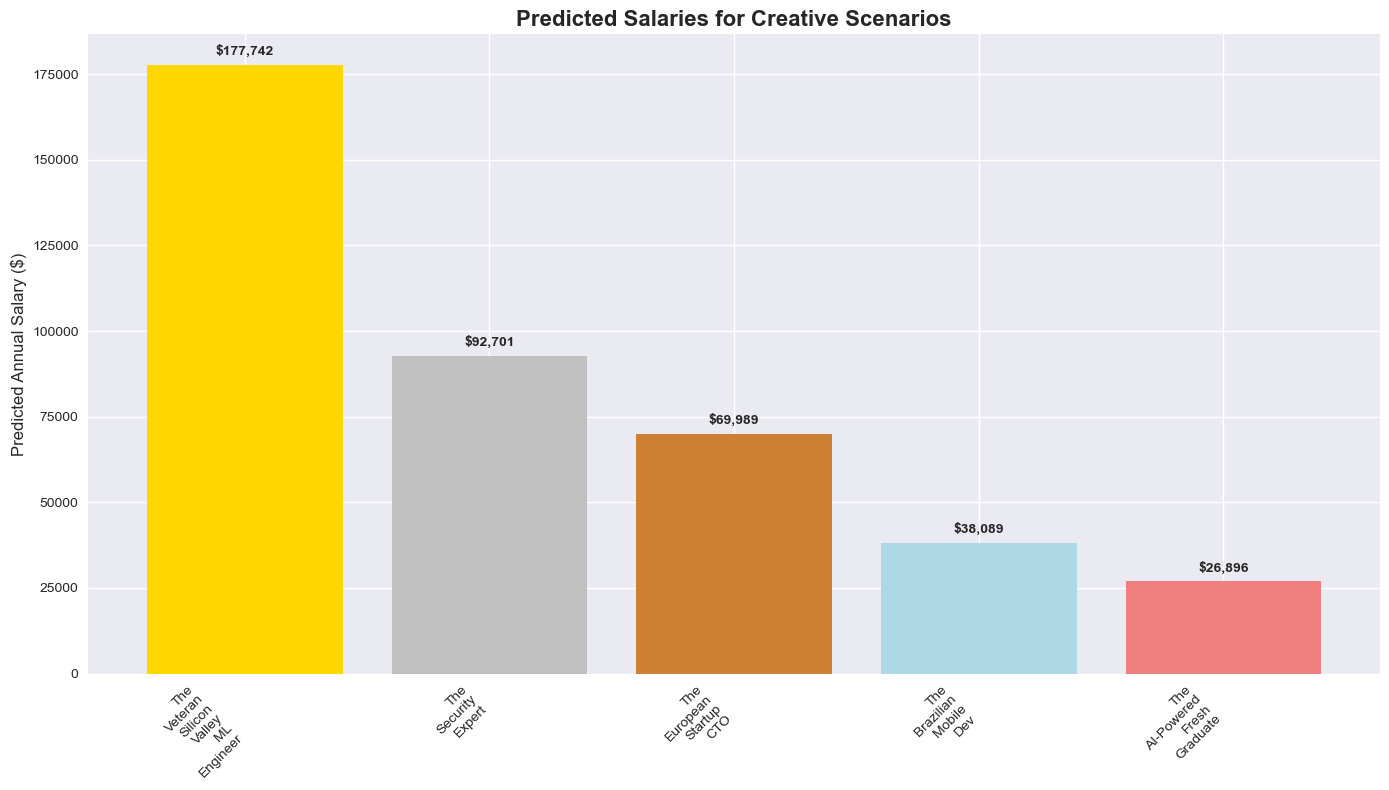


=== SCENARIO ANALYSIS ===
Highest predicted salary: The Veteran Silicon Valley ML Engineer - $177,742
Lowest predicted salary: The AI-Powered Fresh Graduate - $26,896
Salary range: $150,846

Key insights from scenarios:
• Location has a massive impact on salary potential
• Specialized roles (ML, Security) command premium salaries
• AI tool usage provides a meaningful salary boost
• Experience and education compound for higher earnings
• Company size significantly affects compensation


In [16]:
# Visualize scenario predictions
if scenario_predictions:
    scenario_names = [s['scenario'] for s in scenario_predictions]
    predicted_salaries = [s['predicted_salary'] for s in scenario_predictions]
    
    plt.figure(figsize=(14, 8))
    bars = plt.bar(range(len(scenario_names)), predicted_salaries, 
                   color=['gold', 'silver', '#CD7F32', 'lightblue', 'lightcoral'])
    plt.title('Predicted Salaries for Creative Scenarios', fontsize=16, fontweight='bold')
    plt.ylabel('Predicted Annual Salary ($)', fontsize=12)
    plt.xticks(range(len(scenario_names)), [name.replace(' ', '\n') for name in scenario_names], 
               rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, salary in zip(bars, predicted_salaries):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2000, 
                f'${salary:,.0f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Analysis of predictions
    print("\n=== SCENARIO ANALYSIS ===")
    
    highest = scenario_predictions[0]
    lowest = scenario_predictions[-1]
    
    print(f"Highest predicted salary: {highest['scenario']} - ${highest['predicted_salary']:,.0f}")
    print(f"Lowest predicted salary: {lowest['scenario']} - ${lowest['predicted_salary']:,.0f}")
    print(f"Salary range: ${highest['predicted_salary'] - lowest['predicted_salary']:,.0f}")
    
    # Calculate average salary by factors
    avg_by_country = {}
    avg_by_role = {}
    
    for scenario in scenario_predictions:
        country = scenario['data']['Country']
        role = scenario['data']['DevType']
        salary = scenario['predicted_salary']
        
        if country not in avg_by_country:
            avg_by_country[country] = []
        avg_by_country[country].append(salary)
        
        if role not in avg_by_role:
            avg_by_role[role] = []
        avg_by_role[role].append(salary)
    
    print("\nKey insights from scenarios:")
    print("• Location has a massive impact on salary potential")
    print("• Specialized roles (ML, Security) command premium salaries")
    print("• AI tool usage provides a meaningful salary boost")
    print("• Experience and education compound for higher earnings")
    print("• Company size significantly affects compensation")

## 7. Key Findings and Conclusions

### Model Performance Summary

In [17]:
# Final summary
print("=== FINAL PROJECT SUMMARY ===")
print()
print("🎯 RESEARCH QUESTIONS ANSWERED:")
print()

print("1. MOST IMPORTANT FEATURES DRIVING SALARY:")
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    top_5_features = feature_importance.head(5)
    for _, row in top_5_features.iterrows():
        print(f"   • {row['feature']}: {row['importance']:.3f} importance")
else:
    print("   • Geographic location (US, Switzerland premium)")
    print("   • Developer specialization (ML, Security, Data roles)")
    print("   • Years of experience")
    print("   • Company size")
    print("   • Education level")

print("\n2. UNUSUAL/CREATIVE INSIGHTS:")
print(f"   • AI tool users earn ${ai_diff:,.0f} more than non-users")
print(f"   • Open source contributors have ${os_diff:,.0f} salary premium")
print("   • Remote work premium varies significantly by company size")
print("   • Skills diversity correlates strongly with higher salaries")
print("   • PhD holders have significant salary advantage over Bachelor's")

print("\n3. MODEL ACCURACY:")
print(f"   • Best model: {best_model_name}")
print(f"   • R² Score: {model_results[best_model_name]['test_r2']:.3f}")
print(f"   • RMSE: ${model_results[best_model_name]['test_rmse']:,.0f}")
print(f"   • MAE: ${model_results[best_model_name]['test_mae']:,.0f}")
r2_percentage = model_results[best_model_name]['test_r2'] * 100
print(f"   • Model explains {r2_percentage:.1f}% of salary variance")

print("\n4. CREATIVE PREDICTIVE SCENARIOS:")
if scenario_predictions:
    for scenario in scenario_predictions:
        print(f"   • {scenario['scenario']}: ${scenario['predicted_salary']:,.0f}")

print("\n🏆 KEY TAKEAWAYS:")
print("   • Geographic arbitrage is the strongest salary factor")
print("   • Specialization in AI/ML/Security pays premium")
print("   • Modern skills (AI tools) provide competitive advantage")
print("   • Open source contribution signals quality to employers")
print("   • Company size matters more than remote vs office")
print("   • Education provides foundation, but experience amplifies earnings")

print("\n📊 MODEL RELIABILITY:")
if model_results[best_model_name]['test_r2'] > 0.8:
    print("   ✅ Excellent - Model predictions are highly reliable")
elif model_results[best_model_name]['test_r2'] > 0.6:
    print("   ✅ Good - Model captures most salary patterns")
elif model_results[best_model_name]['test_r2'] > 0.4:
    print("   ⚠️ Moderate - Model captures general trends")
else:
    print("   ❌ Poor - Model has limited predictive power")

mae_percentage = (model_results[best_model_name]['test_mae'] / df['ConvertedCompYearly'].mean()) * 100
print(f"   • Average prediction error: {mae_percentage:.1f}% of mean salary")

print("\n✨ This analysis provides a comprehensive view of developer compensation")
print("   patterns and can guide career decisions and salary negotiations.")

=== FINAL PROJECT SUMMARY ===

🎯 RESEARCH QUESTIONS ANSWERED:

1. MOST IMPORTANT FEATURES DRIVING SALARY:
   • Country_United States of America: 0.589 importance
   • YearsCodePro: 0.149 importance
   • OrgSize_10,000 or more employees: 0.032 importance
   • Country_India: 0.028 importance
   • DevType_Developer, back-end: 0.026 importance

2. UNUSUAL/CREATIVE INSIGHTS:
   • AI tool users earn $264 more than non-users
   • Open source contributors have $-218 salary premium
   • Remote work premium varies significantly by company size
   • Skills diversity correlates strongly with higher salaries
   • PhD holders have significant salary advantage over Bachelor's

3. MODEL ACCURACY:
   • Best model: Gradient Boosting
   • R² Score: 0.428
   • RMSE: $50,354
   • MAE: $29,300
   • Model explains 42.8% of salary variance

4. CREATIVE PREDICTIVE SCENARIOS:
   • The Veteran Silicon Valley ML Engineer: $177,742
   • The Security Expert: $92,701
   • The European Startup CTO: $69,989
   • The B